In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import truvari
import pysam
import os
import json
from svteaser.utils import parse_truvari_dir
from pandas.api.types import CategoricalDtype
SZBINTYPE = CategoricalDtype(categories=ts.SZBINS, ordered=True)

In [2]:
EXAMPLEDIR = '../test/results_sv_multi/'
TYPES = ['DUP', 'INS', 'DEL']
sb.set()

In [3]:
vardf, perfdf = parse_truvari_dir(EXAMPLEDIR)

In [4]:
vardf.head()

,state,truscore,seq_sim,size_sim,rec_overlap,start_dist,end_dist,size_diff,num_neigh,num_thresh_neigh,svtype,start,end,svlen,szbin,cnt
0,fp,,,,,,,,,,DUP,1501009,1501107,97,"[50,100)",1
1,fp,,,,,,,,,,DUP,2533553,2533628,74,"[50,100)",1
2,fp,,,,,,,,,,DUP,5447228,5447461,232,"[200,300)",1
3,fp,,,,,,,,,,DUP,7017632,7017755,122,"[100,200)",1
4,fp,,,,,,,,,,INS,8336984,8336989,183,"[100,200)",1


In [5]:
perfdf

,TP-base,TP-call,FP,FN,precision,recall,f1,base cnt,call cnt,base size filtered,call size filtered,base gt filtered,call gt filtered,TP-call_TP-gt,TP-call_FP-gt,TP-base_TP-gt,TP-base_FP-gt,gt_precision,gt_recall,gt_f1
0,4217.0,4224.0,375.0,5424.0,0.918461,0.437403,0.592592,9641.0,4592.0,6309.0,4.0,0.0,0.0,4111.0,113.0,4106.0,111.0,0.89389,0.43085,0.581446


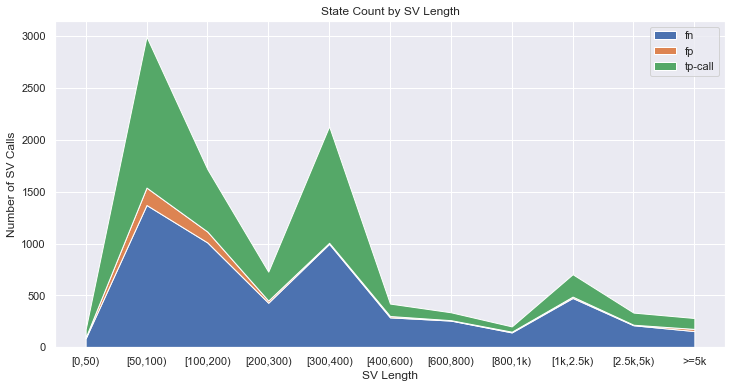

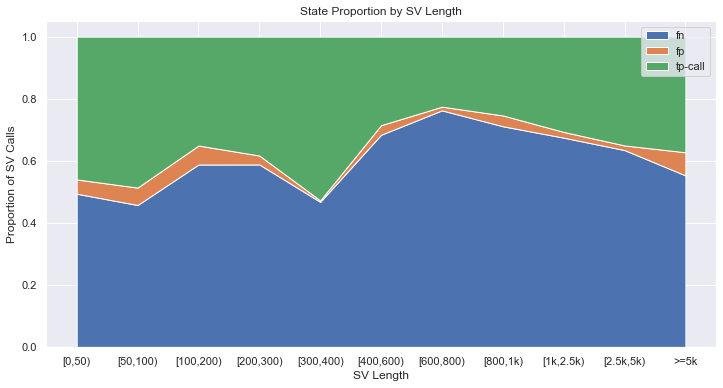

In [8]:
xs = truvari.SZBINS
ys = []
state_labels = []
for state, df in vardf.groupby(["state"]):
    if state == "tp-base": 
        continue
    state_labels.append(state)
    # gets the number of given state for each bin in increasing order
    ys.append(df.groupby('szbin')['state'].count().sort_index().to_list())

ys_sum = [sum(i) for i in zip(*ys)]
ys_scaled = []
for i in range(len(ys)):
    scaled_list = []
    for j in range(len(ys[0])):
        if ys_sum[j] == 0:
            scaled_list.append(0.25)
        else:
            scaled_list.append(ys[i][j] / ys_sum[j])
    
    ys_scaled.append(scaled_list)

# Plot
fig, axs = plt.subplots(figsize=(12,6))
plt.stackplot(xs,ys, labels=state_labels)
axs.set_xticks(axs.get_xticks()[::1])
plt.legend(loc='upper right')
plt.title('State Count by SV Length')
plt.xlabel('SV Length')
plt.ylabel('Number of SV Calls')
plt.show()

# Plot
fig, axs = plt.subplots(figsize=(12,6))
plt.stackplot(xs,ys_scaled, labels=state_labels)
axs.set_xticks(axs.get_xticks()[::1])
plt.legend(loc='upper right')
plt.title('State Proportion by SV Length')
plt.xlabel('SV Length')
plt.ylabel('Proportion of SV Calls')
plt.show()

Text(0.5, 1.0, 'SV Type count by State')

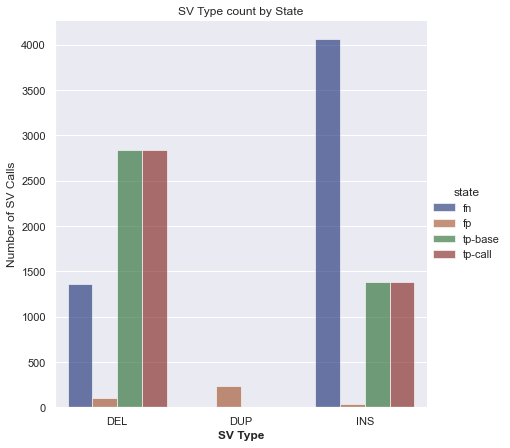

In [9]:
tmpdf = vardf.groupby(["svtype", "state"]).count().reset_index()
sb.catplot(data=tmpdf, kind="bar", x="svtype", y="cnt", hue="state", alpha=.6, height=6, palette="dark")
plt.xlabel('SV Type', fontweight='bold')
plt.ylabel('Number of SV Calls')
plt.title('SV Type count by State')

Text(0.5, 1.0, 'State count by SV Type')

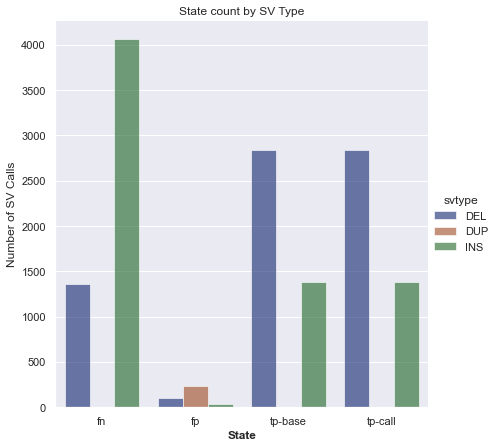

In [10]:
tmpdf = vardf.groupby(["svtype", "state"]).count().reset_index()
sb.catplot(data=tmpdf, kind="bar", x="state", y="cnt", hue="svtype", alpha=.6, height=6, palette="dark")
plt.xlabel('State', fontweight='bold')
plt.ylabel('Number of SV Calls')
plt.title('State count by SV Type')

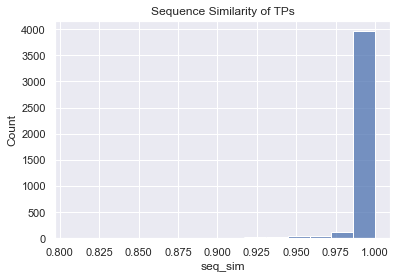

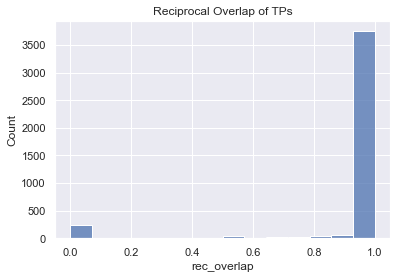

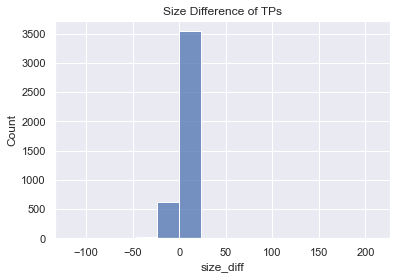

In [14]:
# Plots of how similar true-positives are to the base callset
tmpdf = vardf[vardf["state"] == "tp-call"]
p = sb.histplot(tmpdf["seq_sim"])
p.set(title="Sequence Similarity of TPs")
plt.show()
p = sb.histplot(tmpdf["rec_overlap"])
p.set(title="Reciprocal Overlap of TPs")
plt.show()
p = sb.histplot(tmpdf["size_diff"])
p.set(title="Size Difference of TPs")
plt.show()

In [ ]:
def getPerformanceTable(tdf):
    measures = {}
    counts = tdf['state'].value_counts()
    tp_call = counts['tp-call']
    tp_base = counts['tp-base']
    tp = tp_call + tp_base
    fp = counts['fp']
    fn = counts['fn']
    precision = tp_call / (tp_call + fp)
    recall = tp_base / (tp_base + fn)
    f1 = 2*((recall * precision) / (recall + precision))

    measures['True Positives'] = tp
    measures['False Negatives'] = fn
    measures['False Positives'] = fp
    measures['Precision'] = precision
    measures['Recall'] = recall
    measures['F1'] = f1

    df = pd.DataFrame.from_dict(measures, orient='index', columns=['Value'])

    with pd.option_context('display.float_format', '{:0.2f}'.format):
        display(df)